# How to connect synapses to pre-defined spike trains

In many cases, the user might want to simulate the voltage of a cell in response to (many) pre-defined spike trains (without actually simulating the presynaptic neurons in detail). The easiest way to achieve this in `Jaxley` is to define "dummy" neurons whose voltage is clamped to the pre-defined spike train.

First, generate pre-synaptic spike trains:

In [1]:
import numpy as np

# Generate pre-synaptic spike train.
_ = np.random.seed(42)

t_max = 1_000.0  # ms
dt = 0.025  # ms
time_steps = int(t_max // dt)

firing_rate = 30  # Hz
spike_prob = firing_rate * dt / 1000

spike_train = np.random.binomial(1, spike_prob, size=time_steps)

Next, create a network consisting of a pre-synaptic dummy neuron and the actual neuron which we want to simulate (if you want multiple pre-synaptic spike trains, then insert build multiple dummy neurons). Then, insert a synapse from the dummy neuron to the morphologically detailed cell. Lastly, clamp the voltage of the pre-synaptic dummy to the spike train:

In [7]:
import jaxley as jx
from jaxley.connect import connect
from jaxley.synapses import AlphaSynapse
from jaxley.channels import Leak

dummy = jx.Cell()
cell = jx.read_swc("../../tests/swc_files/morph_ca1_n120.swc", ncomp=1)
net = jx.Network([dummy, cell])
net.cell(1).insert(Leak())

# Connect pre-synaptic dummy to the morphologically detailed cell.
connect(net.cell(0), net.cell(1).branch(5).comp(0), AlphaSynapse())
net.set("AlphaSynapse_gS", 0.005)  # Synaptic strength.
net.set("AlphaSynapse_tau_decay", 5.0)  # decay time in ms

# Clamp the voltage of the pre-synaptic cell to the spike train.
net.cell(0).set("v", 0.0)  # Initial state.
net.cell(0).clamp("v", spike_train)

Added 1 external_states. See `.externals` for details.


Finally, as always, insert recordings, run the simulation, and visualize the voltage response:

Added 1 recordings. See `.recordings` for details.


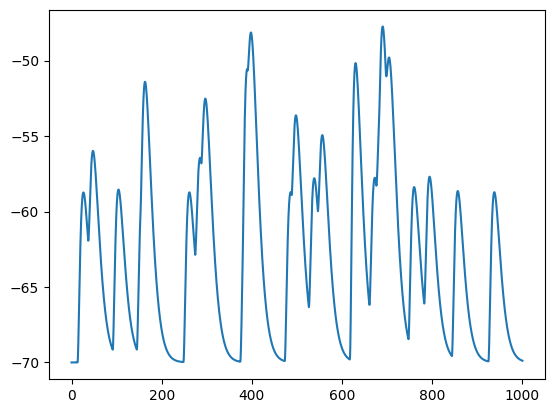

In [8]:
import matplotlib.pyplot as plt

net.cell(1).branch(5).comp(0).record()
v = jx.integrate(net, delta_t=dt)

time_vector = np.arange(0, t_max, dt)
plt.plot(time_vector, v.T)